In [1]:
#-*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
phone_brand_device_model = pd.read_csv('data/phone_brand_device_model.csv')
gender_age_train = pd.read_csv('data/gender_age_train.csv')
label_categories = pd.read_csv('data/label_categories.csv')
events = pd.read_csv('data/events.csv')
app_labels = pd.read_csv('data/app_labels.csv')
app_events = pd.read_csv('data/app_events.csv', dtype = {'event_id' : np.int8, 'app_id' : np.int64, 
                                                   'is_installed' : np.int8, 'is_active' : np.int8})
gender_age_test = pd.read_csv('data/gender_age_test.csv')

### TimeStamp Split

In [3]:
events['timestamp'].replace('-', '', regex = True, inplace = True)
events['timestamp'].replace(':', '', regex = True, inplace = True)
events['timestamp'].replace(' ', '', regex = True, inplace = True)

events['year'] = events['timestamp'].map(lambda x: x[0:4])
events['month'] = events['timestamp'].map(lambda x: x[4:6])
events['day'] = events['timestamp'].map(lambda x: x[6:8])
events['time'] = events['timestamp'].map(lambda x: x[8:10])

events.drop(['timestamp'], axis = 1, inplace = True)
events.drop(['year'], axis = 1, inplace = True)



### 명목형 변수 치환

In [4]:
phone_brand_device_model.phone_brand.fillna(phone_brand_device_model.phone_brand.dropna().max(), inplace = True)
phone_brand_device_model.device_model.fillna(phone_brand_device_model.device_model.dropna().max(), inplace = True)

In [5]:
le_br = LabelEncoder()
le_mo = LabelEncoder()


phone_brand_device_model['brand'] = le_br.fit_transform(phone_brand_device_model['phone_brand'])
phone_brand_device_model['device'] = le_mo.fit_transform(phone_brand_device_model['device_model'])



phone_brand_label = phone_brand_device_model.copy()

phone_brand_label = phone_brand_label.drop('phone_brand', 1)
phone_brand_label = phone_brand_label.drop('device_model', 1)

In [6]:
#M = 1, F = 0
le_gen = LabelEncoder()
gender_age_train['M_F'] = le_gen.fit_transform(gender_age_train['gender'])

In [7]:
#group 치환
le_g = LabelEncoder()
gender_age_train['group_e'] = le_g.fit_transform(gender_age_train['group'])

In [8]:
# evnet_id 에서 minus 뗴어 내기

app_events = app_events[(app_events.event_id > 0)]


In [9]:
app_events.shape

(16098186, 4)

### Data set 기초자료 (train + test)

In [10]:
tmp = pd.merge(gender_age_train, phone_brand_label, how='left', on = 'device_id')
tmp_ = pd.merge(gender_age_test, phone_brand_label,  how='left', on = 'device_id')

In [11]:
con = pd.concat([tmp, tmp_])

tmp = pd.merge(events, con, how='left', on='device_id')


labels = pd.merge(app_labels, app_events, on='app_id')


labels = labels[['app_id', 'label_id', 'event_id']]

tmp = tmp[['device_id', 'age', 'M_F', 'group_e', 'brand', 'device', 'event_id', 'time']]

tmp = pd.merge(tmp, labels, how='left', on='event_id')

del labels

tmp = tmp[['device_id', 'age', 'M_F', 'group_e', 'brand', 'device', 'time', 'label_id']]

tmp = tmp.drop_duplicates(subset=['device_id', 'age', 'M_F', 'group_e', 'brand', 'device', 'time', 'label_id'], keep='first')

In [12]:
tmp.shape

(564683, 8)

In [13]:
tmp.head()

,device_id,age,M_F,group_e,brand,device,time,label_id
0,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,251.0
3,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,691.0
6,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,405.0
9,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,730.0
12,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,751.0


In [12]:
import math

In [13]:
g_sam = pd.DataFrame()

g_sam['brand_m']= tmp.groupby(['brand'])['M_F'].mean()
g_sam['brand_g']= tmp.groupby(['brand'])['group_e'].mean()

g_sam['brand_g'] = g_sam['brand_g'].fillna(-1)

g_sam['brand_m'] = g_sam['brand_m'].apply(lambda x : 1 if x >= 0.5 else 0 )
g_sam['brand_g'] = g_sam['brand_g'].apply(lambda x : math.trunc(x))

g_sam.reset_index()

tmp['brand_m'] = tmp.brand.map(g_sam.brand_m)
tmp['brand_g'] = tmp.brand.map(g_sam.brand_g)

In [14]:
g_d = pd.DataFrame()

g_d['device_m'] = tmp.groupby(['device'])['M_F'].max()
g_d['device_g']= tmp.groupby(['device'])['group_e'].mean()

g_d['device_g'] = g_d['device_g'].fillna(-1)

g_d['device_m'] = g_d['device_m'].apply(lambda x : 1 if x >= 0.5 else 0 )
g_d['device_g'] = g_d['device_g'].apply(lambda x : math.trunc(x))

g_d.reset_index()

tmp['device_m'] = tmp.device.map(g_d.device_m)
tmp['device_g'] = tmp.device.map(g_d.device_g)

In [15]:
g_t = pd.DataFrame()

g_t['time_m'] = tmp.groupby(['time'])['M_F'].mean()
g_t['time_g']= tmp.groupby(['time'])['group_e'].mean()

g_t['time_g'] = g_t['time_g'].fillna(-1)

g_t['time_m'] = g_t['time_m'].apply(lambda x : 1 if x >= 0.5 else 0 )
g_t['time_g'] = g_t['time_g'].apply(lambda x : math.trunc(x))

g_t.reset_index()

tmp['time_m'] = tmp.time.map(g_t.time_m)
tmp['time_g'] = tmp.time.map(g_t.time_g)

In [16]:
g_l = pd.DataFrame()

g_l['label_m'] = tmp.groupby(['label_id'])['M_F'].mean()
g_l['label_g']= tmp.groupby(['label_id'])['group_e'].mean()

g_l['label_g'] = g_l['label_g'].fillna(-1)

g_l['label_m'] = g_l['label_m'].apply(lambda x : 1 if x >= 0.5 else 0 )
g_l['label_g'] = g_l['label_g'].apply(lambda x : math.trunc(x))

g_l.reset_index()

tmp['label_m'] = tmp.label_id.map(g_l.label_m)
tmp['label_g'] = tmp.label_id.map(g_l.label_g)

In [17]:
tmp.head()

,device_id,age,M_F,group_e,brand,device,time,label_id,brand_m,brand_g,device_m,device_g,time_m,time_g,label_m,label_g
0,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,251.0,1.0,7.0,1.0,7.0,1,7,1.0,7.0
3,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,691.0,1.0,7.0,1.0,7.0,1,7,1.0,7.0
6,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,405.0,1.0,7.0,1.0,7.0,1,7,1.0,7.0
9,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,730.0,1.0,7.0,1.0,7.0,1,7,1.0,7.0
12,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,751.0,1.0,7.0,1.0,7.0,1,7,1.0,7.0


## 변수 추가
* brand별 연령대
* model별 연령대
* <s>time(hour)별 연령대</s>
* label별 연령대

In [18]:
tmp_sam = tmp[['device_id', 'age', 'M_F', 'group_e', 'brand', 'device', 'time', 'label_id']]

In [19]:
# brand가 key로 있는데 붙여서 파생 할 수 있다. 
#t = tmp.copy()

agebrand_train = pd.merge(gender_age_train, phone_brand_label, how='left', on = 'device_id')
agebrand_test = pd.merge(gender_age_test, phone_brand_label,  how='left', on = 'device_id')

agebradn_all = pd.concat([agebrand_train, agebrand_test])

In [20]:
g_brand = pd.DataFrame()
g_model = pd.DataFrame()

g_brand_tmp = pd.DataFrame()
g_model_tmp = pd.DataFrame()

g_brand['brand_group_count'] = tmp_sam.groupby(['brand','group_e'])['group_e'].count()
g_brand.reset_index()
g_brand = g_brand.unstack()
#g_brand = g_brand.applymap(encode_units)
# one hot으로 변경하지 않음. 사용자 수가 영향 줄 수 있으므로 유지
brand_group = phone_brand_label.join(g_brand, how='left', on='brand')

C:\Python36\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [21]:
g_model['model_g_count'] = tmp_sam.groupby(['device', 'group_e'])['group_e'].count()
g_model.reset_index()
g_model = g_model.unstack()
#g_model = g_model.applymap(encode_units)

brand_group = brand_group.join(g_model, how='left', on='device', rsuffix='_')

C:\Python36\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [88]:
brand_group.head()

,device_id,brand,device,"(brand_group_count, 0.0)","(brand_group_count, 1.0)","(brand_group_count, 2.0)","(brand_group_count, 3.0)","(brand_group_count, 4.0)","(brand_group_count, 5.0)","(brand_group_count, 6.0)","(brand_group_count, 7.0)","(brand_group_count, 8.0)","(brand_group_count, 9.0)","(brand_group_count, 10.0)","(brand_group_count, 11.0)","(model_g_count, 0.0)","(model_g_count, 1.0)","(model_g_count, 2.0)","(model_g_count, 3.0)","(model_g_count, 4.0)","(model_g_count, 5.0)","(model_g_count, 6.0)","(model_g_count, 7.0)","(model_g_count, 8.0)","(model_g_count, 9.0)","(model_g_count, 10.0)","(model_g_count, 11.0)"
0,-8890648629457979026,51,1517,1495.0,1440.0,1596.0,2272.0,2699.0,2717.0,2813.0,5435.0,3783.0,4960.0,6329.0,5870.0,25.0,19.0,8.0,86.0,23.0,92.0,28.0,98.0,486.0,65.0,113.0,216.0
1,1277779817574759137,51,749,1495.0,1440.0,1596.0,2272.0,2699.0,2717.0,2813.0,5435.0,3783.0,4960.0,6329.0,5870.0,29.0,2.0,4.0,34.0,86.0,49.0,28.0,44.0,43.0,44.0,137.0,86.0
2,5137427614288105724,15,560,953.0,1160.0,1012.0,1571.0,2871.0,1927.0,1190.0,2601.0,1717.0,3016.0,4958.0,6059.0,103.0,145.0,66.0,193.0,161.0,170.0,117.0,303.0,176.0,197.0,513.0,1137.0
3,3669464369358936369,9,1503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-5019277647504317457,15,536,953.0,1160.0,1012.0,1571.0,2871.0,1927.0,1190.0,2601.0,1717.0,3016.0,4958.0,6059.0,88.0,40.0,121.0,160.0,343.0,287.0,84.0,220.0,183.0,182.0,292.0,452.0


### time별 그룹 비율

* 모든 시간에 앱 사용 유저는 다 있다. 그러므로 나이별 나눌 필요 없음

g_time_sum = pd.DataFrame()
g_time = pd.DataFrame()

g_time['group_size'] = tmp_sam.groupby(['time', 'group_e'])['group_e'].count()
g_time.reset_index()
g_time = g_time.unstack()
g_time = g_time.applymap(encode_units)

time_onehot = events.join(g_time, how='left', on='time', rsuffix='_')

### label별 그룹 ratio

In [22]:
g_label = pd.DataFrame()
g_app_label_sum = pd.DataFrame()

g_label['count'] = tmp_sam.groupby(['label_id', 'group_e'])['group_e'].count()
g_label.reset_index()
g_label = g_label.unstack()
#g_label = g_label.applymap(encode_units)

label_group = label_categories.join(g_label, how='left', on='label_id', rsuffix='_')

C:\Python36\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [23]:
label_group = label_group.drop('category', 1)

In [24]:
label_group.head(100)

,label_id,"(count, 0.0)","(count, 2.0)","(count, 3.0)","(count, 5.0)","(count, 6.0)","(count, 7.0)","(count, 8.0)","(count, 9.0)","(count, 10.0)","(count, 11.0)"
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
5,6,2.0,3.0,2.0,2.0,3.0,6.0,6.0,6.0,5.0,10.0
6,7,2.0,3.0,2.0,2.0,3.0,6.0,6.0,6.0,5.0,10.0
7,8,2.0,3.0,2.0,2.0,3.0,6.0,6.0,6.0,5.0,10.0
8,9,2.0,3.0,2.0,2.0,3.0,6.0,6.0,6.0,5.0,10.0
9,10,2.0,3.0,2.0,2.0,3.0,6.0,6.0,6.0,5.0,10.0


In [33]:
brand_group.head()

,device_id,brand,device,"(brand_group_count, 0.0)","(brand_group_count, 1.0)","(brand_group_count, 2.0)","(brand_group_count, 3.0)","(brand_group_count, 4.0)","(brand_group_count, 5.0)","(brand_group_count, 6.0)","(brand_group_count, 7.0)","(brand_group_count, 8.0)","(brand_group_count, 9.0)","(brand_group_count, 10.0)","(brand_group_count, 11.0)","(model_g_count, 0.0)","(model_g_count, 1.0)","(model_g_count, 2.0)","(model_g_count, 3.0)","(model_g_count, 4.0)","(model_g_count, 5.0)","(model_g_count, 6.0)","(model_g_count, 7.0)","(model_g_count, 8.0)","(model_g_count, 9.0)","(model_g_count, 10.0)","(model_g_count, 11.0)"
0,-8890648629457979026,51,1517,1495.0,1440.0,1596.0,2272.0,2699.0,2717.0,2813.0,5435.0,3783.0,4960.0,6329.0,5870.0,25.0,19.0,8.0,86.0,23.0,92.0,28.0,98.0,486.0,65.0,113.0,216.0
1,1277779817574759137,51,749,1495.0,1440.0,1596.0,2272.0,2699.0,2717.0,2813.0,5435.0,3783.0,4960.0,6329.0,5870.0,29.0,2.0,4.0,34.0,86.0,49.0,28.0,44.0,43.0,44.0,137.0,86.0
2,5137427614288105724,15,560,953.0,1160.0,1012.0,1571.0,2871.0,1927.0,1190.0,2601.0,1717.0,3016.0,4958.0,6059.0,103.0,145.0,66.0,193.0,161.0,170.0,117.0,303.0,176.0,197.0,513.0,1137.0
3,3669464369358936369,9,1503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-5019277647504317457,15,536,953.0,1160.0,1012.0,1571.0,2871.0,1927.0,1190.0,2601.0,1717.0,3016.0,4958.0,6059.0,88.0,40.0,121.0,160.0,343.0,287.0,84.0,220.0,183.0,182.0,292.0,452.0


In [37]:
tmp = pd.merge(tmp, label_group, how ='left', on='label_id')

In [ ]:
tmp = pd.merge(tmp, brand_group, how ='left', on='device_id')

In [47]:
tmp = tmp.drop(['brand_y', 'device_y'], 1)

In [48]:
tmp.head()

,device_id,age,M_F,group_e,brand_x,device_x,time,label_id,brand_m,brand_g,device_m,device_g,time_m,time_g,label_m,label_g,"(brand_group_count, 0.0)","(brand_group_count, 1.0)","(brand_group_count, 2.0)","(brand_group_count, 3.0)","(brand_group_count, 4.0)","(brand_group_count, 5.0)","(brand_group_count, 6.0)","(brand_group_count, 7.0)","(brand_group_count, 8.0)","(brand_group_count, 9.0)","(brand_group_count, 10.0)","(brand_group_count, 11.0)","(model_g_count, 0.0)","(model_g_count, 1.0)","(model_g_count, 2.0)","(model_g_count, 3.0)","(model_g_count, 4.0)","(model_g_count, 5.0)","(model_g_count, 6.0)","(model_g_count, 7.0)","(model_g_count, 8.0)","(model_g_count, 9.0)","(model_g_count, 10.0)","(model_g_count, 11.0)","(count, 0.0)","(count, 2.0)","(count, 3.0)","(count, 5.0)","(count, 6.0)","(count, 7.0)","(count, 8.0)","(count, 9.0)","(count, 10.0)","(count, 11.0)"
0,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,251,1.0,7.0,1.0,7.0,1,7,1.0,7.0,1495.0,1440.0,1596.0,2272.0,2699.0,2717.0,2813.0,5435.0,3783.0,4960.0,6329.0,5870.0,164.0,239.0,326.0,432.0,542.0,620.0,348.0,606.0,456.0,668.0,982.0,1574.0,2.0,3.0,2.0,2.0,3.0,6.0,6.0,6.0,5.0,10.0
1,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,691,1.0,7.0,1.0,7.0,1,7,1.0,7.0,1495.0,1440.0,1596.0,2272.0,2699.0,2717.0,2813.0,5435.0,3783.0,4960.0,6329.0,5870.0,164.0,239.0,326.0,432.0,542.0,620.0,348.0,606.0,456.0,668.0,982.0,1574.0,2.0,3.0,2.0,2.0,3.0,6.0,6.0,6.0,5.0,10.0
2,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,405,1.0,7.0,1.0,7.0,1,7,1.0,7.0,1495.0,1440.0,1596.0,2272.0,2699.0,2717.0,2813.0,5435.0,3783.0,4960.0,6329.0,5870.0,164.0,239.0,326.0,432.0,542.0,620.0,348.0,606.0,456.0,668.0,982.0,1574.0,2.0,3.0,2.0,2.0,3.0,6.0,6.0,6.0,5.0,10.0
3,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,730,1.0,7.0,1.0,7.0,1,7,1.0,7.0,1495.0,1440.0,1596.0,2272.0,2699.0,2717.0,2813.0,5435.0,3783.0,4960.0,6329.0,5870.0,164.0,239.0,326.0,432.0,542.0,620.0,348.0,606.0,456.0,668.0,982.0,1574.0,2.0,3.0,2.0,2.0,3.0,6.0,6.0,6.0,5.0,10.0
4,29182687948017175,46.0,1.0,11.0,51.0,1524.0,00,751,1.0,7.0,1.0,7.0,1,7,1.0,7.0,1495.0,1440.0,1596.0,2272.0,2699.0,2717.0,2813.0,5435.0,3783.0,4960.0,6329.0,5870.0,164.0,239.0,326.0,432.0,542.0,620.0,348.0,606.0,456.0,668.0,982.0,1574.0,2.0,3.0,2.0,2.0,3.0,6.0,6.0,6.0,5.0,10.0


In [39]:
tmp.shape

(566930, 52)

In [50]:
tmp_label = tmp[['device_id', 'label_id']]

In [51]:
tmp_label.head()

,device_id,label_id
0,29182687948017175,251
1,29182687948017175,691
2,29182687948017175,405
3,29182687948017175,730
4,29182687948017175,751


In [53]:
from sklearn.preprocessing import OneHotEncoder

In [54]:
onehot = OneHotEncoder(sparse = False)

In [57]:
tmp_label.shape

(566930, 2)

In [59]:
tmp_label.fillna(0, inplace=True)

C:\Python36\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [71]:
tmp_label = tmp_label.set_index('device_id')

In [79]:
tmp_label = tmp_label.reset_index()

In [93]:
tmp_label.head()

,device_id,label_id
0,29182687948017175,251.0
1,29182687948017175,691.0
2,29182687948017175,405.0
3,29182687948017175,730.0
4,29182687948017175,751.0


In [108]:
tmp = pd.get_dummies(tmp)

In [110]:
tmp.head()

,device_id,age,M_F,group_e,brand_x,device_x,brand_m,brand_g,device_m,device_g,time_m,time_g,label_m,label_g,"(brand_group_count, 0.0)","(brand_group_count, 1.0)","(brand_group_count, 2.0)","(brand_group_count, 3.0)","(brand_group_count, 4.0)","(brand_group_count, 5.0)","(brand_group_count, 6.0)","(brand_group_count, 7.0)","(brand_group_count, 8.0)","(brand_group_count, 9.0)","(brand_group_count, 10.0)","(brand_group_count, 11.0)","(model_g_count, 0.0)","(model_g_count, 1.0)","(model_g_count, 2.0)","(model_g_count, 3.0)","(model_g_count, 4.0)","(model_g_count, 5.0)","(model_g_count, 6.0)","(model_g_count, 7.0)","(model_g_count, 8.0)","(model_g_count, 9.0)","(model_g_count, 10.0)","(model_g_count, 11.0)","(count, 0.0)","(count, 2.0)","(count, 3.0)","(count, 5.0)","(count, 6.0)","(count, 7.0)","(count, 8.0)","(count, 9.0)","(count, 10.0)","(count, 11.0)",time_00,time_23,label_id_5.0,label_id_6.0,label_id_7.0,label_id_8.0,label_id_9.0,label_id_10.0,label_id_11.0,label_id_12.0,label_id_13.0,label_id_14.0,label_id_16.0,label_id_17.0,label_id_18.0,label_id_19.0,label_id_20.0,label_id_22.0,label_id_23.0,label_id_24.0,label_id_25.0,label_id_26.0,label_id_27.0,label_id_29.0,label_id_30.0,label_id_31.0,label_id_32.0,label_id_33.0,label_id_35.0,label_id_36.0,label_id_37.0,label_id_38.0,label_id_39.0,label_id_40.0,label_id_41.0,label_id_42.0,label_id_43.0,label_id_44.0,label_id_45.0,label_id_46.0,label_id_47.0,label_id_48.0,label_id_49.0,label_id_50.0,label_id_51.0,label_id_52.0,label_id_54.0,label_id_55.0,label_id_56.0,label_id_57.0,label_id_58.0,label_id_59.0,label_id_60.0,label_id_61.0,label_id_62.0,label_id_63.0,label_id_64.0,label_id_65.0,label_id_66.0,label_id_67.0,label_id_68.0,label_id_69.0,label_id_70.0,label_id_71.0,label_id_72.0,label_id_73.0,label_id_74.0,label_id_75.0,label_id_76.0,label_id_77.0,label_id_78.0,label_id_79.0,label_id_80.0,label_id_81.0,label_id_82.0,label_id_83.0,label_id_84.0,label_id_85.0,label_id_86.0,label_id_87.0,label_id_88.0,label_id_89.0,label_id_90.0,label_id_91.0,label_id_92.0,label_id_93.0,label_id_94.0,label_id_95.0,label_id_96.0,label_id_97.0,label_id_98.0,label_id_99.0,label_id_100.0,label_id_101.0,label_id_102.0,label_id_103.0,label_id_104.0,label_id_105.0,label_id_128.0,label_id_129.0,label_id_130.0,label_id_131.0,label_id_132.0,label_id_134.0,label_id_135.0,label_id_136.0,label_id_137.0,label_id_138.0,label_id_139.0,label_id_140.0,label_id_141.0,label_id_142.0,label_id_144.0,label_id_147.0,label_id_148.0,label_id_149.0,label_id_150.0,label_id_151.0,label_id_152.0,label_id_153.0,label_id_154.0,label_id_155.0,label_id_156.0,label_id_157.0,label_id_158.0,label_id_159.0,label_id_160.0,label_id_161.0,label_id_162.0,label_id_163.0,label_id_164.0,label_id_166.0,label_id_167.0,label_id_168.0,label_id_169.0,label_id_170.0,label_id_172.0,label_id_173.0,label_id_174.0,label_id_175.0,label_id_177.0,label_id_178.0,label_id_179.0,label_id_180.0,label_id_181.0,label_id_183.0,label_id_184.0,label_id_185.0,label_id_186.0,label_id_187.0,label_id_188.0,label_id_189.0,label_id_190.0,label_id_191.0,label_id_192.0,label_id_193.0,label_id_194.0,label_id_195.0,label_id_197.0,label_id_198.0,label_id_199.0,label_id_200.0,label_id_201.0,label_id_203.0,label_id_204.0,label_id_205.0,label_id_206.0,label_id_207.0,label_id_209.0,label_id_210.0,label_id_211.0,label_id_212.0,label_id_213.0,label_id_214.0,label_id_215.0,label_id_216.0,label_id_217.0,label_id_218.0,label_id_219.0,label_id_220.0,label_id_221.0,label_id_222.0,label_id_223.0,label_id_224.0,label_id_225.0,label_id_226.0,label_id_227.0,label_id_229.0,label_id_230.0,label_id_231.0,label_id_232.0,label_id_233.0,label_id_234.0,label_id_235.0,label_id_236.0,label_id_237.0,label_id_238.0,label_id_240.0,label_id_241.0,label_id_242.0,label_id_245.0,label_id_246.0,label_id_247.0,label_id_249.0,label_id_250.0,label_id_251.0,label_id_252.0,label_id_253.0,label_id_254.0,label_id_255.0,label_id_256.0,label_id_257.0,label_id_258.0,label_id_259.0,label_id_260.0,label_id_261.0,label

# train / test 분리

In [111]:
train = pd.merge(gender_age_train, tmp, on = 'device_id')
test = pd.merge(gender_age_test, tmp, on = 'device_id')

In [112]:
X = train.copy()

y = train.group_e_x

X = X.drop(['device_id', 'gender','age_x', 'group', 'M_F_x', 'group_e_x', 'age_y','M_F_y', 'group_e_y'],1)

In [116]:
test.head(1000)

,device_id,age,M_F,group_e,brand,device,time,label_id,brand_m,brand_g,device_m,device_g,time_m,time_g,label_m,label_g,"(brand_group_count, 0.0)","(brand_group_count, 1.0)","(brand_group_count, 2.0)","(brand_group_count, 3.0)","(brand_group_count, 4.0)","(brand_group_count, 5.0)","(brand_group_count, 6.0)","(brand_group_count, 7.0)","(brand_group_count, 8.0)","(brand_group_count, 9.0)","(brand_group_count, 10.0)","(brand_group_count, 11.0)","(model_g_count, 0.0)","(model_g_count, 1.0)","(model_g_count, 2.0)","(model_g_count, 3.0)","(model_g_count, 4.0)","(model_g_count, 5.0)","(model_g_count, 6.0)","(model_g_count, 7.0)","(model_g_count, 8.0)","(model_g_count, 9.0)","(model_g_count, 10.0)","(model_g_count, 11.0)","(group_size, 0.0)","(group_size, 1.0)","(group_size, 2.0)","(group_size, 3.0)","(group_size, 4.0)","(group_size, 5.0)","(group_size, 6.0)","(group_size, 7.0)","(group_size, 8.0)","(group_size, 9.0)","(group_size, 10.0)","(group_size, 11.0)","(count, 0.0)","(count, 2.0)","(count, 3.0)","(count, 5.0)","(count, 6.0)","(count, 7.0)","(count, 8.0)","(count, 9.0)","(count, 10.0)","(count, 11.0)"
0,1002079943728939269,NaN,NaN,NaN,51.0,1482.0,21,NaN,1.0,7.0,1.0,7.0,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1002079943728939269,NaN,NaN,NaN,51.0,1482.0,22,NaN,1.0,7.0,1.0,7.0,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1002079943728939269,NaN,NaN,NaN,51.0,1482.0,08,NaN,1.0,7.0,1.0,7.0,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1002079943728939269,NaN,NaN,NaN,51.0,1482.0,16,NaN,1.0,7.0,1.0,7.0,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1002079943728939269,NaN,NaN,NaN,51.0,1482.0,09,NaN,1.0,7.0,1.0,7.0,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-1547860181818787117,NaN,NaN,NaN,51.0,1519.0,20,NaN,1.0,7.0,1.0,7.0,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-1547860181818787117,NaN,NaN,NaN,51.0,1519.0,13,NaN,1.0,7.0,1.0,7.0,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-1547860181818787117,NaN,NaN,NaN,51.0,1519.0,18,NaN,1.0,7.0,1.0,7.0,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-1547860181818787117,NaN,NaN,NaN,51.0,1519.0,14,NaN,1.0,7.0,1.0,7.0,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,7374582448058474277,NaN,NaN,NaN,31.0,1371.0,21,NaN,1.0,7.0,0.0,-1.0,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
test_e = test.drop(['device_id', 'age', 'M_F', 'group_e'], 1)

In [97]:
from sklearn import preprocessing

In [98]:
min_max_scaler = preprocessing.MinMaxScaler()

X_min_max = min_max_scaler.fit_transform(X)
test_e_min_max = min_max_scaler.fit_transform(test_e)

# randomforest nan 제거

In [56]:
X.fillna(-1, inplace = True)
test_e.fillna(-1, inplace = True)

## train_test_split

In [57]:
from sklearn.model_selection import train_test_split

In [107]:
type(X_min_max)

numpy.ndarray

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_min_max, y, random_state = 1)

# Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt

In [53]:
forest = RandomForestClassifier(criterion = 'gini', n_estimators = 10, random_state = 1, n_jobs = -1)

In [100]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [101]:
importance = forest.feature_importances_

In [102]:
featurename = X.columns

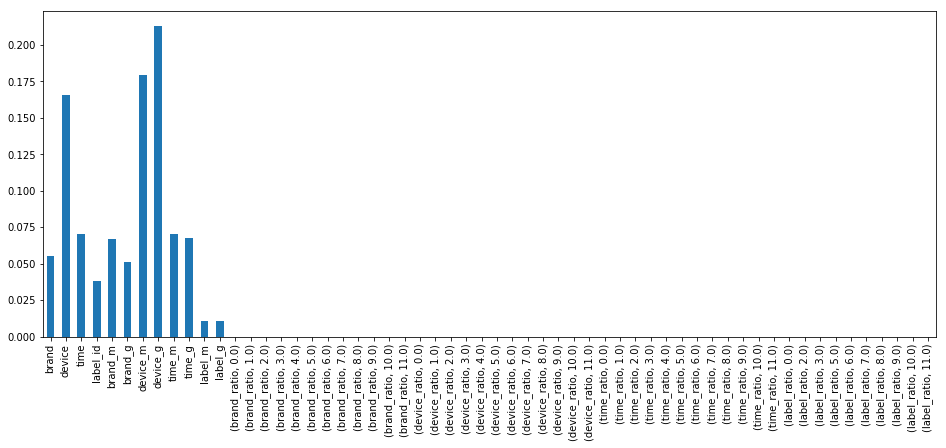

In [103]:
pd.Series(importance, index = featurename).plot(kind='bar', figsize=(16,6))

In [104]:
y_ped = forest.predict(X_test)

In [63]:
from sklearn.metrics import f1_score

In [105]:
f1_score(y_test, y_ped, average = 'macro')

0.19621754416302459

In [61]:
result_rf = pd.DataFrame(y_prona_rf_test, columns = le.classes_)
device_id = test_model["device_id"].values
result_rf['device_id'] = device_id  
result_rf = result_rf.set_index('device_id')
result_rf = result_rf.drop_duplicates(['device_id'], keep='first')



NameError: name 'y_prona_rf_test' is not defined

# 예측

In [ ]:
y_prona_rf_test = forest.predict_proba()

In [ ]:
from sklearn.metrics import accuracy_score